# Regularyzacja w modelu regresji - wstęp

In [2]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from scipy import stats
from patsy import dmatrices

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Zadanie 1a

Wygeneruj $n$ par punktów (x, y) takich, że
$$
y = x - 2x^2 + 0.5x^3 + e,
$$
gdzie $e\sim\mathcal{N}(\mu, \sigma)$. 
A następnie dopasuj model

a) regresji liniowej: $y=\beta_0 + \beta_1\cdot x$

b) regresji wielomianowej stopnia 2: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2$,

c) regresji wielomianowej stopnia 3: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \beta_3\cdot x^3$,

d) regresji wielomianowej stopnia 20: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \ldots + \beta_{20}\cdot x^{20}$.

Zaznacz na wykresie rozproszenia punktów $(x, y)$ funkcję regresji.

**Wskazówka**: `ols('y ~ x + I(x**k)', data_frame)` z `statsmodels.formula.api` lub `PolynomialFeatures` z `sklearn.preprocessing`

In [3]:
#generujemy dane
n = 50
x = stats.uniform.rvs(size=n, loc=-3, scale=6)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + stats.norm.rvs(size=n, loc=2, scale=2)

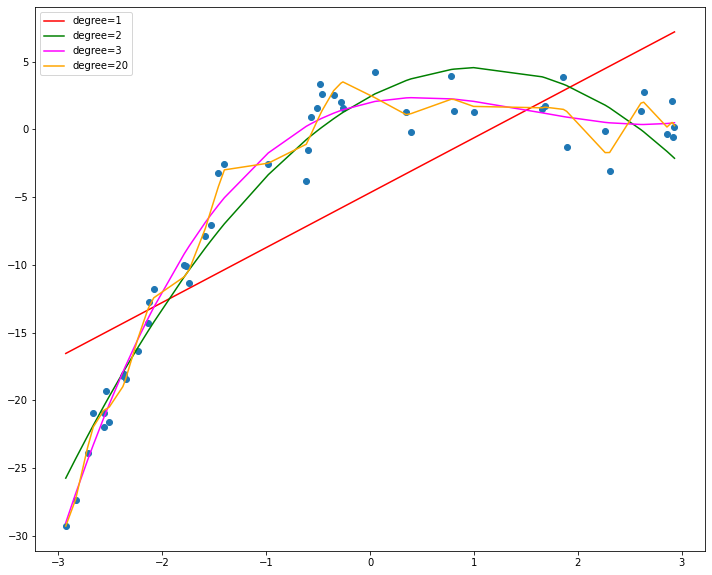

In [4]:
#rysujemy dopasowanie dla modeli wielomianowych o rzędzie wielomianu równym: 1, 2, 3 i 20
import operator

colors = ['red', 'green', 'magenta', 'orange']
degrees = [1, 2, 3, 20]

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

for i, deg in enumerate(degrees):
    if deg == 1:
        X = add_constant(x, prepend=True, has_constant='skip')
    else:
        polynomial_features = PolynomialFeatures(degree=deg)
        X = polynomial_features.fit_transform(x.reshape(-1, 1))
    model = OLS(endog=y, exog=X).fit()
    
    sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, color=colors[i], label="degree={}".format(deg))

plt.legend()

# Zadanie 1b

Dla wygenerowanej pary punktów dopasuj model regresji:

a) wielomianowej stopnia 20 z regularyzacją grzbietową (Ridge) z parametrem $\alpha = 0.1$,

b) wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha = 0.1$.

Powtórz podpunkt a) i b) dla różnych wartości parametru $\alpha$, np. $\alpha \in \{0.001, 0.005, 0.01, 0.5, 1, 5\}$.

In [5]:
# Rigde - powinno wygładzać wielomian (zwalczamy problem przeuczenia modelu)
# Sposob I
X = x.reshape(-1, 1)
polynomial_features_20 = PolynomialFeatures(degree=20,include_bias = False)
X20 = polynomial_features_20.fit_transform(X)

In [6]:
X20.shape

(50, 20)

In [7]:
X20

array([[-1.53526616e+00,  2.35704217e+00, -3.61868707e+00,
         5.55564778e+00, -8.52939801e+00,  1.30948961e+01,
        -2.01041508e+01,  3.08652223e+01, -4.73863311e+01,
         7.27506304e+01, -1.11691581e+02,  1.71476304e+02,
        -2.63261765e+02,  4.04176878e+02, -6.20519082e+02,
         9.52661945e+02, -1.46258964e+03,  2.24546438e+03,
        -3.44738546e+03,  5.29265422e+03],
       [-2.81451479e-01,  7.92149352e-02, -2.22951607e-02,
         6.27500596e-03, -1.76610971e-03,  4.97074191e-04,
        -1.39902266e-04,  3.93756998e-05, -1.10823490e-05,
         3.11914351e-06, -8.77887556e-07,  2.47082751e-07,
        -6.95418059e-08,  1.95726441e-08, -5.50874965e-09,
         1.55044574e-09, -4.36375247e-10,  1.22818459e-10,
        -3.45674369e-11,  9.72905625e-12],
       [-2.66533681e+00,  7.10402031e+00, -1.89346068e+01,
         5.04671046e+01, -1.34511831e+02,  3.58519336e+02,
        -9.55574783e+02,  2.54692864e+03, -6.78842266e+03,
         1.80934328e+04, -4.8

In [8]:
X20_scale = StandardScaler().fit_transform(X20) # (x - mean) / std (aby móc użyć Ridge lub Lasso najpierw trzeba zeskalować kolumny X)
X20_scale

array([[-5.86521337e-01, -4.74840328e-01, -1.62558290e-01,
        -6.97207131e-01, -2.15904253e-02, -6.95093430e-01,
        -1.44324611e-03, -6.40596004e-01, -1.61737463e-02,
        -5.84585542e-01, -3.68966597e-02, -5.37904552e-01,
        -5.55846581e-02, -5.00863827e-01, -7.07309559e-02,
        -4.71641354e-01, -8.26062863e-02, -4.48400014e-01,
        -9.18288005e-02, -4.29687912e-01],
       [ 7.91422178e-02, -1.26083891e+00,  1.33347651e-01,
        -9.27795989e-01,  7.37707067e-02, -7.61375241e-01,
         2.75112017e-02, -6.59477832e-01, -7.64047301e-03,
        -5.89923312e-01, -3.44275929e-02, -5.39404800e-01,
        -5.48788156e-02, -5.01283771e-01, -7.05308247e-02,
        -4.71758569e-01, -8.25498675e-02, -4.48432665e-01,
        -9.18129612e-02, -4.29696994e-01],
       [-1.18648787e+00,  1.16317595e+00, -1.42273009e+00,
         1.16896440e+00, -1.43040211e+00,  1.05339135e+00,
        -1.34873836e+00,  8.98610037e-01, -1.23009171e+00,
         7.37605952e-01, -1.1

In [9]:
ridge01 = Ridge(alpha=0.1).fit(X=X20_scale, y=y) #definiujemy Ridge z zadanym parametrem i od razu dopasowujemy do zeskalowanych danych
ridge01

Ridge(alpha=0.1)

In [10]:
#żeby porównanie było fair z ridge robimy to na zeskalowanych danych
lm =  LinearRegression().fit(X20_scale,y)

In [11]:
print(ridge01.coef_) # [b1, b2, ..., b20] w ridge (bez wyrazu wolnego)
print(lm.coef_) # [b1, b2, ..., b20] w zwykłym lm (bez wyrazu wolnego)


[ 3.24961641e+00 -5.17028077e+00  3.81653777e+00 -1.95598917e+00
  5.67824733e-01 -1.50522069e-02  4.79742768e-03  1.22530640e+00
  2.27681733e-01  1.51852766e+00  3.89977563e-01  1.14867702e+00
  3.15624444e-01  4.53698434e-01  7.14006342e-02 -3.14070184e-01
 -2.38840836e-01 -9.95386419e-01 -5.39235957e-01 -1.50287449e+00]
[-1.44538229e+01 -1.39661477e+01  6.29987377e+02 -3.09034132e+02
 -7.93132166e+03  7.21477377e+03  4.87717707e+04 -5.69206529e+04
 -1.68700906e+05  2.31864351e+05  3.52103204e+05 -5.51004988e+05
 -4.53454942e+05  7.93284166e+05  3.52890284e+05 -6.81527673e+05
 -1.52281979e+05  3.21474374e+05  2.79960501e+04 -6.40671109e+04]


In [12]:
print(ridge01.intercept_) 
print(lm.intercept_) 
# wyrazy wolne poszczególnych metod

-6.423664134466504
-6.423664134536216


In [13]:
ridge01_params = [ridge01.intercept_] + list(ridge01.coef_[1:])
ridge01_params # wyraz wolny i wspolczynniki regresji grzbietowej

[-6.423664134466504,
 -5.170280768510526,
 3.816537773397452,
 -1.9559891655596984,
 0.5678247332303089,
 -0.015052206887418597,
 0.004797427679539009,
 1.2253064049014113,
 0.22768173340552272,
 1.5185276647518604,
 0.3899775634753402,
 1.148677015138074,
 0.3156244439081321,
 0.45369843395232506,
 0.07140063419756101,
 -0.31407018436087325,
 -0.23884083563079922,
 -0.995386418623596,
 -0.5392359565399263,
 -1.5028744933131564]

In [14]:
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params))
ridge01_r2 = ridge01.score(X20_scale, y)
print("R2: {}".format(ridge01_r2))

Współczynniki regresji z regularyzacja Ridge: [-6.423664134466504, -5.170280768510526, 3.816537773397452, -1.9559891655596984, 0.5678247332303089, -0.015052206887418597, 0.004797427679539009, 1.2253064049014113, 0.22768173340552272, 1.5185276647518604, 0.3899775634753402, 1.148677015138074, 0.3156244439081321, 0.45369843395232506, 0.07140063419756101, -0.31407018436087325, -0.23884083563079922, -0.995386418623596, -0.5392359565399263, -1.5028744933131564]
R2: 0.9744800531778494


In [15]:
#dla porównania regresja zwykła
lm_r2 = lm.score(X20_scale, y)
print("R2: {}".format(lm_r2))
#nieco wyżej, ale to na zb. treningowym, więc nic dziwnego

R2: 0.9854822173517755


In [16]:
## Sposob 2 - pipeline

ridge01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Ridge(alpha=0.1)
)
ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)

In [17]:
ridge01_pipeline['ridge']

Ridge(alpha=0.1)

In [18]:
ridge01_params = [ridge01_pipeline['ridge'].intercept_] + list(ridge01_pipeline['ridge'].coef_[1:])
print("Współczynniki regresji z regularyzacja Ridge: {}".format(ridge01_params)) #współczynniki
ridge01_r2 = ridge01_pipeline['ridge'].score(X20_scale, y)
print("R2: {}".format(ridge01_r2)) #R^2

Współczynniki regresji z regularyzacja Ridge: [-6.423664134466504, -5.170280768510526, 3.816537773397452, -1.9559891655596984, 0.5678247332303089, -0.015052206887418597, 0.004797427679539009, 1.2253064049014113, 0.22768173340552272, 1.5185276647518604, 0.3899775634753402, 1.148677015138074, 0.3156244439081321, 0.45369843395232506, 0.07140063419756101, -0.31407018436087325, -0.23884083563079922, -0.995386418623596, -0.5392359565399263, -1.5028744933131564]
R2: 0.9744800531778494


In [19]:
ridge01.predict(X20_scale) #wartości dopasowane

array([ -6.38200671,   1.45067673, -22.81421003,   0.67174876,
       -14.13951735,   0.39208819, -21.10176501,   0.3493807 ,
        -0.04049236,  -1.69181608, -13.4317267 ,   0.47596218,
         2.16143388,  -0.07473274,   0.52673709,   0.26545163,
        -6.93065646,  -8.71470332,   2.5053892 , -14.33361766,
         1.00307169,   0.94114321, -26.42912856,   2.48126888,
         0.43290744,  -0.05170939, -18.08812441,  -9.16259345,
        -5.61385887,   2.27041373, -23.82222634,   2.44678205,
       -20.9985169 , -29.52452652,   0.50643487,   2.46542205,
         1.01271178,   0.86980409, -17.66934109, -20.19673799,
         0.87386987, -17.90056103,   1.50585342,  -9.36232799,
        -5.04545741,   0.79626468,   1.2457865 ,   1.151964  ,
       -20.68814143, -15.77727753])

In [20]:
ridge01_fittedvalues = ridge01_pipeline.predict(X) #wartości dopasowane obliczone za pomocą pipeline'a
ridge01_fittedvalues
#to samo co wcześniej - metody są równoważne

array([ -6.38200671,   1.45067673, -22.81421003,   0.67174876,
       -14.13951735,   0.39208819, -21.10176501,   0.3493807 ,
        -0.04049236,  -1.69181608, -13.4317267 ,   0.47596218,
         2.16143388,  -0.07473274,   0.52673709,   0.26545163,
        -6.93065646,  -8.71470332,   2.5053892 , -14.33361766,
         1.00307169,   0.94114321, -26.42912856,   2.48126888,
         0.43290744,  -0.05170939, -18.08812441,  -9.16259345,
        -5.61385887,   2.27041373, -23.82222634,   2.44678205,
       -20.9985169 , -29.52452652,   0.50643487,   2.46542205,
         1.01271178,   0.86980409, -17.66934109, -20.19673799,
         0.87386987, -17.90056103,   1.50585342,  -9.36232799,
        -5.04545741,   0.79626468,   1.2457865 ,   1.151964  ,
       -20.68814143, -15.77727753])

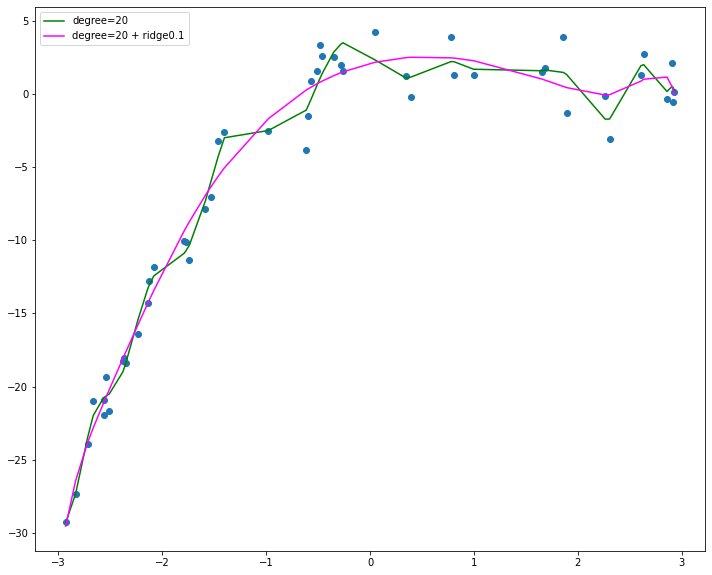

In [21]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()#jeśli chodzi o watości dopasowane, nie jest ważne, czy dopasowujemy model na zeskalowanych X-ach czy nie

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))


plt.legend()
#widzimy, że ridge się nie przeuczyło

In [22]:
#teraz pipeline dla lasso
lasso01_pipeline = make_pipeline(
    PolynomialFeatures(degree=20,include_bias = False),
    StandardScaler(),
    Lasso(alpha=0.1, max_iter=10e5)
)
lasso01_pipeline.fit(X, y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=20, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=1000000.0))])

In [23]:
lasso01_params = [lasso01_pipeline['lasso'].intercept_] + list(lasso01_pipeline['lasso'].coef_[1:])
print("Współczynniki regresji z regularyzacja Lasso: {}".format(lasso01_params))
lasso01_r2 = lasso01_pipeline.score(X, y)
print("R2: {}".format(lasso01_r2))

Współczynniki regresji z regularyzacja Lasso: [-6.423664134466504, -5.390911986607737, 4.8711840494371375, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0]
R2: 0.9729263374899034


In [24]:
lasso01_fittedvalues = lasso01_pipeline.predict(X) #wartości dopasowane

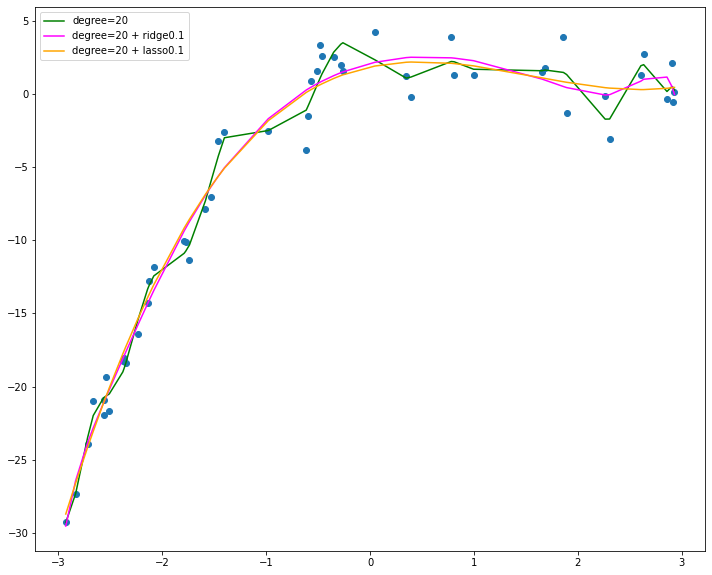

In [25]:
#wykres dopasowania dla regresji wielomianowej bez kary, z karą ridge i z karą lasso
plt.scatter(x, y)
sort_axis = operator.itemgetter(0)


polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[3], label="degree={} + lasso0.1".format(deg))

plt.legend()

#widzimy, że i ridge i lasso się nie przeuczyło

# Zadanie 2

Narysuj wykres funkcji 
$$y = cos(x) + \epsilon$$
dla $x \in [\frac{\pi}{2}, \frac{3}{2}\pi]$ oraz $\epsilon \in N(0, 0.15)$.

Dopasuj model regresji:
- liniowej
- wielomianej stopnia 2, 10 i 20,
- wielomianej stopnia 20 z regularyzacja Ridge z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.
- wielomianej stopnia 20 z regularyzacją Lasso z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.

**Wskazówka**: Napisz funkcję, która dla dowolnego zbioru dopasuje odpowiedni model.

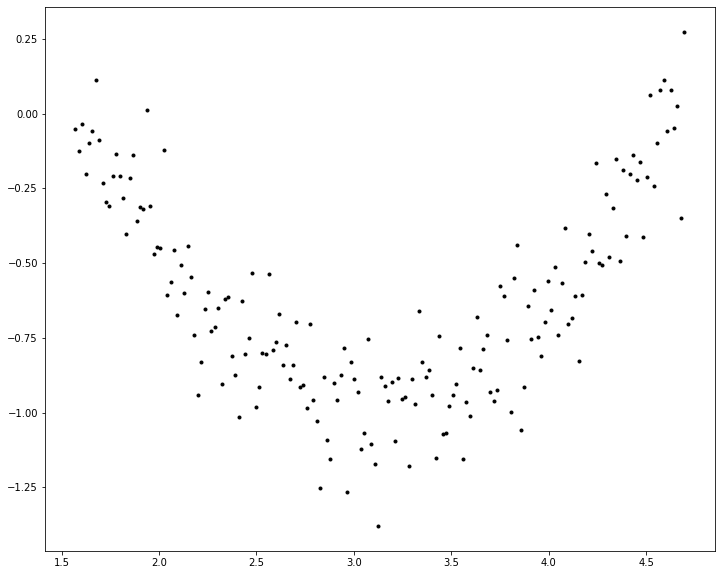

In [26]:
#generacja danych
x = np.array([i*np.pi/180 for i in range(90,270,1)])
X = pd.DataFrame(x)
y = np.cos(x)+np.random.normal(0,0.15,len(x))
plt.plot(x,y,'.',color = 'black')

In [27]:
#funkcja dopasowywująca modele, które nas interesują
def fit_model(X,y,model,power):
  new_model = make_pipeline(
      PolynomialFeatures(degree = power,include_bias = False),
      StandardScaler(),
      model
  )
  new_model.fit(X,y)
  return(new_model.predict(X))

In [28]:
#tworzymy modele
models = {}
models['linear_regression'] = {'power': 1, 'model': LinearRegression()}
models['polynomial_regression2'] = {'power': 2, 'model': LinearRegression()}
models['polynomial_regression10'] = {'power': 10, 'model': LinearRegression()}
models['polynomial_regression20'] = {'power': 20, 'model': LinearRegression()}
models['ridge_regression_0.1'] = {'power': 20, 'model': Ridge(alpha = 0.1)}
models['lasso_regression_0.1'] = {'power': 20, 'model': Lasso(alpha = 0.1)}

In [ ]:
#definiujemy miarę RSS (czyli właściwie MSE razy liczba obserwacji)
def rss_fun(y,y_pred):
  return(sum((y-y_pred)**2))

In [ ]:
#liczymy RSS dla każdego modelu na danych na których uczyliśmy model
y_pred_dict = {}
rss = {}
for key,values in zip(models,models.values()):
  y_pred = fit_model(X,y,values['model'],values['power'])
  y_pred_dict[key] = y_pred
  rss[key] = rss_fun(y_pred,y)

In [ ]:
pd.DataFrame(list(rss.items()),columns = ['Model','RSS'])
#nie dziwi, że RSS najmniejsze dla regresji wielomianu 20 stopnia, bo ten model najlepiej dopasuje się do danych na których był uczony, 
#ale na innym zbiorze danych już pewnie taki nie będzie (overfitting) 

,Model,RSS
0,linear_regression,21.138022
1,polynomial_regression2,4.629805
2,polynomial_regression10,4.305702
3,polynomial_regression20,4.132432
4,ridge_regression_0.1,4.442151
5,lasso_regression_0.1,17.732358


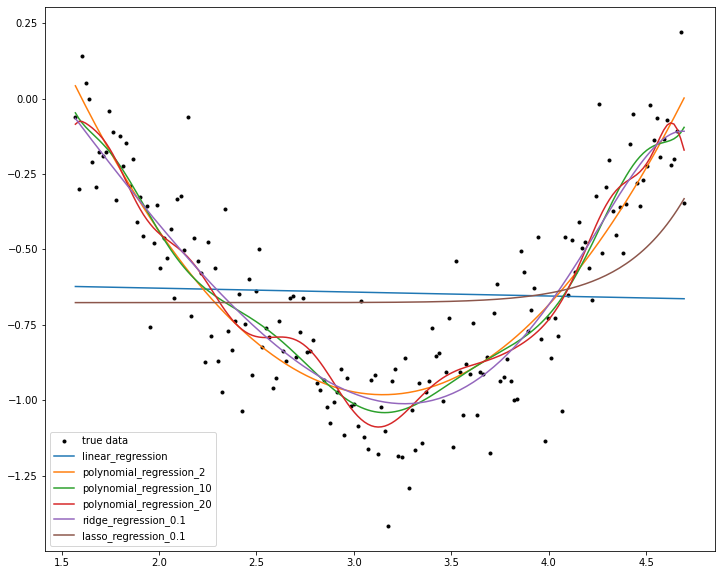

In [ ]:
rcParams['figure.figsize'] = 12, 10

labels = ['true data'] + ['linear_regression', 'polynomial_regression_2', 
                          'polynomial_regression_10', 'polynomial_regression_20', 
                          'ridge_regression_0.1', 'lasso_regression_0.1']

plt.plot(x, y, '.', color = 'black', label="data")
for y_pred in y_pred_dict.values():
    plt.plot(x, y_pred)
plt.legend(labels)

#polynomial 20 przeuczony, ridge z alpha = 0.1 ok, lasso z alpha = 0.1 niedouczony